In [1]:
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
#DGP: noise sigma, context generation, btheta generation
#hyparameters: para1 for ETC, para1-3 for LETC

In [8]:
#sample context--Example 1
def sample(d):
  x=2*np.random.rand(d-1)-1
  x=np.insert(x,0,1)
  return x
def noise(sigma2=0.0001):
  return np.sqrt(sigma2)*np.random.randn()
def demandh(alpha,beta,x,p):
  return np.dot(alpha,x)+np.dot(beta,x)*p+noise()
def priceh(alpha,beta,x,lb=1/2,ub=3/2):
  return min([max([np.dot(alpha,x),lb]),ub])/min([max([-np.dot(beta,x),lb]),ub])/2
def regret(alpha,beta,x,p):
  return -np.dot(beta,x)*(p-priceh(alpha,beta,x))**2

sample(3)

array([ 1.        , -0.18402112, -0.86451865])

In [9]:
# generate ground truth theta
def sampletheta(d):
  alpha=np.zeros([d])
  beta=np.zeros([d])
  alpha[0]=1;alpha[1]=alpha[2]=1/5
  beta[0]=-1;beta[1]=beta[2]=1/5
  return np.hstack([alpha,beta])
sampletheta(10)

array([ 1. ,  0.2,  0.2,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. , -1. ,
        0.2,  0.2,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ])

In [10]:
#ETC

def ETC(theta,l,u,T,para1=5):
  d=len(theta)//2
  alpha=theta[0:d]
  beta=theta[d:2*d]
  T1=int(np.ceil(np.sqrt(d*T)/para1))
  X=np.zeros([0,2*d])
  D=np.zeros([0,1])
  totreg=[]
  for t in range(T1):
    xt=sample(d)
    pt=l+(t%2)*(u-l)
    X=np.vstack([X,np.hstack([xt,xt*pt])])
    D=np.vstack([D,demandh(alpha,beta,xt,pt)])
    regt=regret(alpha,beta,xt,pt)
    totreg.append(regt)
  thetah=np.linalg.lstsq(X,D)[0]
  alphah=thetah[0:d].reshape(d)
  betah=thetah[d:2*d].reshape(d)
  for t in range(T1,T):
    xt=sample(d)
    pt=priceh(alphah,betah,xt)
    regt=regret(alpha,beta,xt,pt)
    totreg.append(regt)
  return totreg

0.042919320525786946
[92, 5092, 10000]
64.78006953381163


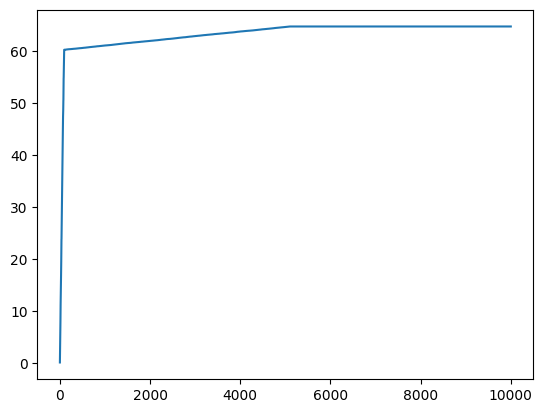

In [11]:
#LETC

def LETC(theta,l,u,T,para1=100,para2=1,para3=100):
  d=len(theta)//2
  alpha=theta[0:d]
  beta=theta[d:2*d]
  T1=int(np.ceil(np.sqrt(T)*np.log(T))/para1)
  eta=np.sqrt(para2*d*np.log(T)/(np.sqrt(T)))
  T2=T1+int(np.ceil(T/para3/d))
  X=np.zeros([0,2*d])
  D=np.zeros([0,1])
  totreg=[]
  for t in range(T1):
    xt=sample(d)
    pt=l+(t%2)*(u-l)
    X=np.vstack([X,np.hstack([xt,xt*pt])])
    D=np.vstack([D,demandh(alpha,beta,xt,pt)])
    regt=regret(alpha,beta,xt,pt)
    totreg.append(regt)
  thetah=np.linalg.lstsq(X,D,rcond=None)[0]
  alphah=thetah[0:d].reshape(d)
  betah=thetah[d:2*d].reshape(d)
  xi=np.random.binomial(size=T2-T1,n=1,p=0.5)
  Xl=X;Dl=D
  for t in range(T1,T2):
    xt=sample(d)
    pt=max(min(priceh(alphah,betah,xt)+eta*xi[t-T1],u),l)
    regt=regret(alpha,beta,xt,pt)
    totreg.append(regt)
    Xl=np.vstack([Xl,np.hstack([xt,xt*pt])])
    Dl=np.vstack([Dl,demandh(alpha,beta,xt,pt)])
  thetad=np.linalg.lstsq(Xl,Dl,rcond=None)[0]   #d stands for dagger
  alphad=thetad[0:d].reshape(d)
  betad=thetad[d:2*d].reshape(d)
  for t in range(T2,T):
    xt=sample(d)
    pt=max(min(priceh(alphad,betad,xt),u),l)
    regt=regret(alpha,beta,xt,pt)
    totreg.append(regt)
  print(eta)
  print([T1,T2,T])
  return totreg

#small test
np.random.seed(20240915)
theta=sampletheta(4)
l=1/6
u=3/2
T=10000
totreg1=LETC(theta,l,u,T,10,0.005,0.5)
print(np.sum(totreg1))
plt.plot(np.cumsum(totreg1))

In [12]:
#parameter tuning for LETC
'''
np.random.seed(20240915)
theta=sampletheta(5)
l=1/6
u=1/3
T=10000

P1=[20,50,100]
P2=[1,2,4,8]
P3=[20,50,100]
v=10000
for p1 in P1:
  for p2 in P2:
    for p3 in P3:
      totreg1=LETC(theta,l,u,T,para1=p1,para2=p2,para3=p3)
      print([p1,p2,p3,np.sum(totreg1)])
      if np.sum(totreg1)<v:
        v=np.sum(totreg1)
        pm1=p1
        pm2=p2
        pm3=p3
print([pm1,pm2,pm3,v])
'''

'\nnp.random.seed(20240915)\ntheta=sampletheta(5)\nl=1/6\nu=1/3\nT=10000\n\nP1=[20,50,100]\nP2=[1,2,4,8]\nP3=[20,50,100]\nv=10000\nfor p1 in P1:\n  for p2 in P2:\n    for p3 in P3:\n      totreg1=LETC(theta,l,u,T,para1=p1,para2=p2,para3=p3)\n      print([p1,p2,p3,np.sum(totreg1)])\n      if np.sum(totreg1)<v:\n        v=np.sum(totreg1)\n        pm1=p1\n        pm2=p2\n        pm3=p3\nprint([pm1,pm2,pm3,v])\n'

In [ ]:
#plot: independent of d
seed=[(2024+100000*i)%10007 for i in range(20)]

l=1/6
u=3/2
T=200000
D=[4,8,16,32,64]
#time_range=[list(range(100,10000,1000))+list(range(10000,T,20000)) for d in D]
time_range=[[2**i for i in range(7,18)] for d in D]
reg=[np.zeros([len(seed),len(time_range[i])]) for i in range(len(D))]

from time import time
start=time()

for inds in range(len(seed)):
  s=seed[inds]
  np.random.seed(s)
  for indd in range(len(D)):
    d=D[indd]
    theta=sampletheta(d)
    indt=0

    for t in time_range[indd]:
      totreg1=LETC(theta,l,u,t,10,0.005,0.5)
      #totreg1=LETC(theta,l,u,t,10,1,1)
      reg[indd][inds,indt]=np.sum(totreg1)
      indt+=1
print(f'time elapsed {time()-start}')

In [ ]:
for i in range(len(D)):
    filename = f'reg_{D[i]}.csv'
    np.savetxt(filename, reg[i], delimiter=',')
for i in range(len(D)):
    files.download(f'reg_{D[i]}.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

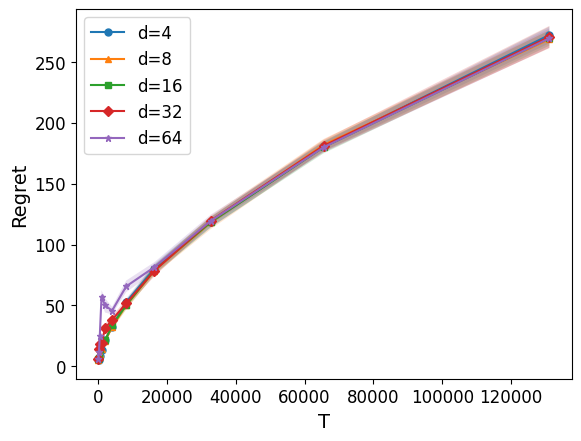

In [3]:
#regret
D=[4,8,16,32,64]
time_range=[[2**i for i in range(7,18)] for d in D]
dot_types = ['o', '^', 's', 'D', '*']
color_types = ['b', 'g', 'r', 'c', 'm']

plt.figure(1)

for indd in range(len(D)):
  regrets=np.loadtxt(f'reg_{D[indd]}.csv',delimiter=',')
  plt.plot(time_range[indd],np.mean(regrets,axis=0),label=f'd={D[indd]}',marker=dot_types[indd],markersize=5)
  plt.fill_between(time_range[indd],np.mean(regrets,axis=0)-np.std(regrets,axis=0),
                   np.mean(regrets,axis=0)+np.std(regrets,axis=0),alpha=0.2)

plt.xlabel('T',fontsize=14)
plt.ylabel('Regret',fontsize=14)
plt.xticks(fontsize=12)  # Font size for X-axis ticks
plt.yticks(fontsize=12)  # Font size for Y-axis ticks
plt.legend(fontsize=12)

plt.savefig('regret-d.pdf')
#files.download("regret-d.pdf")

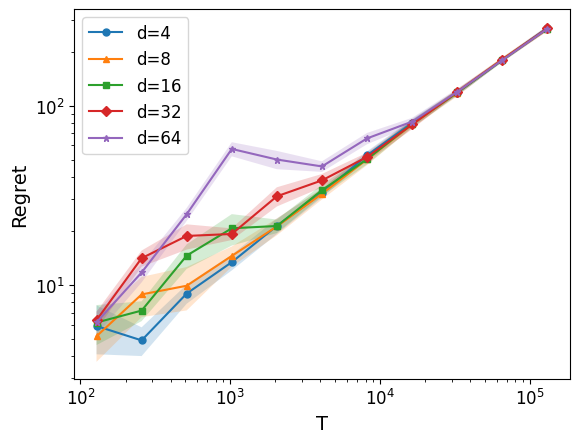

In [7]:
#log-regret
plt.figure(2)
for indd in range(len(D)):
  regrets=np.loadtxt(f'reg_{D[indd]}.csv',delimiter=',')
  plt.loglog(time_range[indd],np.mean(regrets,axis=0),label=f'd={D[indd]}',marker=dot_types[indd],markersize=5)
  plt.fill_between(time_range[indd],np.mean(regrets,axis=0)-np.std(regrets,axis=0),
                   np.mean(regrets,axis=0)+np.std(regrets,axis=0),alpha=0.2)

plt.xlabel('T',fontsize=14)
plt.ylabel('Regret',fontsize=14)
plt.xticks(fontsize=12)  # Font size for X-axis ticks
plt.yticks(fontsize=12)  # Font size for Y-axis ticks
plt.legend(fontsize=12)

plt.savefig('log-regret-d.pdf')
#files.download("log-regret-d.pdf")

In [ ]:
############test for LETC with doubling trick
from time import time
start=time()

seed=[(2024+100000*i)%10007 for i in range(20)]

l=1/6
u=3/2
T=200000
D=[4,8,16,32,64]
reg_dt=[np.zeros([len(seed),2*T]) for i in range(len(D))]
for inds in range(len(seed)):
  s=seed[inds]
  np.random.seed(s)
  for indd in range(len(D)):
    d=D[indd]
    theta=sampletheta(d)
    ini_t=16
    sum_t=0
    t=ini_t
    while sum_t<T:
      reg_dt[indd][inds,sum_t:sum_t+t]=LETC(theta,l,u,t,para1=10,para2=0.005,para3=0.5)
      #10,1,1;10,1,5
      sum_t+=t
      t*=2
print(f'time elapsed{time()-start}')


0.11774100225154747
[1, 9, 16]
0.11069429431256535
[2, 18, 32]
0.1019666990168809
[3, 35, 64]
0.0926134912167217
[5, 69, 128]
0.08325546111576977
[8, 136, 256]
0.07425599004127935
[14, 270, 512]
0.06581922119335398
[22, 534, 1024]
0.058048577658484715
[34, 1058, 2048]
0.05098334950844045
[53, 2101, 4096]
0.044622296600696006
[81, 4177, 8192]
0.038939176384136326
[124, 8316, 16384]
0.033893067312906394
[188, 16572, 32768]
0.02943525056288687
[284, 33052, 65536]
0.025513774189583987
[426, 65962, 131072]
0.16651092223153954
[1, 5, 16]
0.1565453722941489
[2, 10, 32]
0.14420268866008829
[3, 19, 64]
0.13097525533740934
[5, 37, 128]
0.11774100225154747
[8, 72, 256]
0.10501382820381873
[14, 142, 512]
0.09308243527647585
[22, 278, 1024]
0.08209308580109692
[34, 546, 2048]
0.07210134433004414
[53, 1077, 4096]
0.06310545703693915
[81, 2129, 8192]
0.05506831135008373
[124, 4220, 16384]
0.047932035464336456
[188, 8380, 32768]
0.041627730557884886
[284, 16668, 65536]
0.0360819254862343
[426, 33194, 

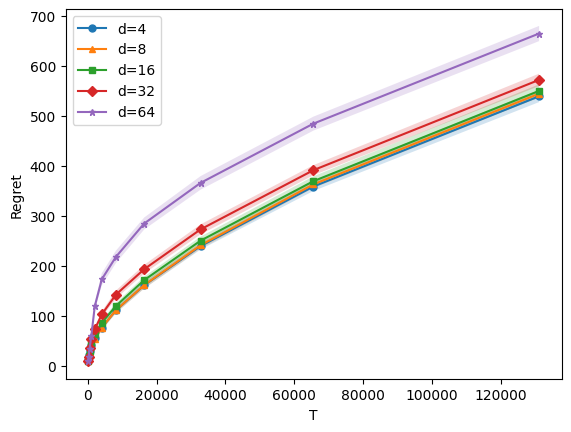

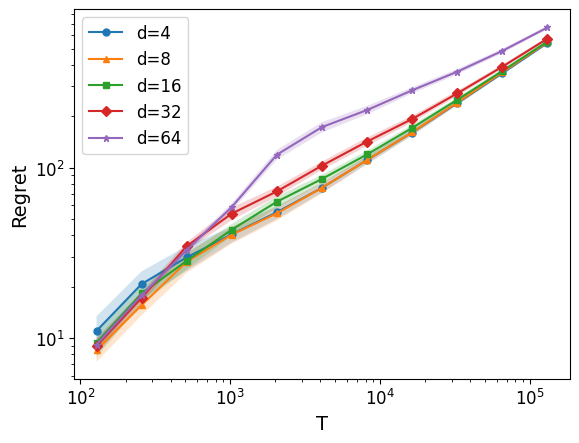

In [ ]:
plt.figure(3)
alpha=0.95

#time_range=[list(range(100,10000,1000))+list(range(10000,T,20000)) for d in D]
time_range=[[2**i for i in range(7,18)] for d in D]
for indd in range(len(D)):
  regrets=np.zeros([len(seed),len(time_range[indd])])
  for i in range(len(seed)):
    for t in range(len(time_range[indd])):
      regrets[i,t]=np.sum(reg_dt[indd][i,0:time_range[indd][t]])
  plt.plot(time_range[indd],np.mean(regrets,axis=0),label=f'd={D[indd]}',marker=dot_types[indd],markersize=5)
  plt.fill_between(time_range[indd],np.mean(regrets,axis=0)-np.std(regrets,axis=0),
                   np.mean(regrets,axis=0)+np.std(regrets,axis=0),alpha=0.2)

plt.xlabel('T')
plt.ylabel('Regret')
plt.legend()


plt.figure(4)
for indd in range(len(D)):
  regrets=np.zeros([len(seed),len(time_range[indd])])
  for i in range(len(seed)):
    for t in range(len(time_range[indd])):
      regrets[i,t]=np.sum(reg_dt[indd][i,0:time_range[indd][t]])
  plt.loglog(time_range[indd],np.mean(regrets,axis=0),label=f'd={D[indd]}',marker=dot_types[indd],markersize=5)
  plt.fill_between(time_range[indd],np.mean(regrets,axis=0)-np.std(regrets,axis=0),
                   np.mean(regrets,axis=0)+np.std(regrets,axis=0),alpha=0.2)

plt.xlabel('T',fontsize=14)
plt.ylabel('Regret',fontsize=14)
plt.xticks(fontsize=12)  # Font size for X-axis ticks
plt.yticks(fontsize=12)  # Font size for Y-axis ticks
plt.legend(fontsize=12)

plt.savefig('log-regret-d-dt.pdf')